In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/content/drive/drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/Handwriting_recog_train

/content/drive/MyDrive/Handwriting_recog_train


In [ ]:
ls

annotations.csv  arial.ttf  dataset/  vgg16.png


In [1]:
import cv2
import os
import csv
import numpy as np
import shutil
from skimage.feature import hog
from skimage.morphology import skeletonize
from skimage import exposure
import random

import itertools
import numpy as np
import tensorflow as tf
from keras import layers, models, Model, Input, activations
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Folder paths
annotation_csv = 'annotations.csv'
dataset_folder = 'dataset'  # Folder containing original images
# dataset_folder = 'drive/MyDrive/Handwriting_recog_train'  # Folder containing original images

# Alpha
# alpha = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
alpha = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

# Load annotations
with open(annotation_csv, 'r') as file:
    reader = csv.reader(file)
    annotations = list(reader)[1:]  # Skip header


In [ ]:
# annotations

In [ ]:
ls

annotations.csv  dataset/


In [ ]:
blah = cv2.imread("dataset/a1.jpg")
if blah is None:
    print("blah")

In [3]:
letterList = []
for annotation in annotations:
    _, letter, _, _, _, _ = annotation
    letterList.append(letter)
alphaIndexes = {}
for i in alpha:
    alphaIndexes[i] = []
for i in range(len(letterList)):
    try:
        alphaIndexes[letterList[i]].append(i)
    except:
        pass
for i, j in alphaIndexes.items():
    print(i, len(j))
# alphaIndexes

a 307
b 96
c 178
d 219
e 507
f 54
g 110
h 168
i 301
j 13
k 40
l 145
m 134
n 398
o 377
p 125
q 28
r 259
s 293
t 363
u 154
v 60
w 65
x 28
y 79
z 19


In [5]:
# flag = annotations[0][0]
c = 0
image_list1, image_list2, image_list3, image_list4, image_list5 = [], [], [], [], []
label_list = []

# Feature extraction steps
for annotation in annotations:
    c += 1
    image_name1, letter, center_x, center_y, dist_x, dist_y = annotation

    # Load original image
    image_name1 = image_name1.replace('\\', '/')
    # image_path = os.path.join(dataset_folder, image_name)
    # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(image_name1, cv2.IMREAD_GRAYSCALE)
    image_name = image_name1[image_name1.find('\\')+1:image_name1.find('.')]

    if img is None:
        # print(f"Error: {image_path}_{c} not found!")
        print(f"Error: {image_name1}_{c} not found!")
        continue

    # Crop the letter using the annotation box
    start_x = int(float(center_x) - float(dist_x) / 2)
    start_y = int(float(center_y) - float(dist_y) / 2)
    end_x = int(float(center_x) + float(dist_x) / 2)
    end_y = int(float(center_y) + float(dist_y) / 2)
    cropped = img[start_y:end_y, start_x:end_x]

    # 1. Image Enhancement & Normalization (Histogram Equalization)
    resized = cv2.resize(cropped, (64, 64))
    enhanced = cv2.equalizeHist(resized)
    norm_image = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX)
    image_list1.append(norm_image)
    label_list.append(letter)

    # 2. Segmentation (Thresholding)
    _, segmented = cv2.threshold(norm_image, 30, 255, cv2.THRESH_BINARY_INV)
    image_list2.append(segmented)

    # 3. Edge Detection (Canny)
    edges = cv2.Canny(segmented, 100, 200)
    image_list3.append(edges)

    # 4. Skeletonization
    binary = segmented / 255  # Convert to binary (0, 1)
    skeleton = skeletonize(binary).astype(np.uint8) * 255
    image_list4.append(skeleton)

    # 5. HOG (Histogram of Oriented Gradients)
    hog_features, hog_image = hog(segmented, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)
    image_list5.append(hog_image)


In [36]:
# label_list

['a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'H',
 'H'

In [6]:
alphaIndexes = {}
for i in alpha:
    alphaIndexes[i] = []
for i in range(len(label_list)):
    try:
        alphaIndexes[label_list[i]].append(i)
    except:
        pass
# alphaIndexes

In [9]:
indexes = [i for i in range(len(label_list))]
xrl, xtl = train_test_split(indexes, test_size=0.2, random_state=42)

In [8]:
splitIndexes = {}
for i in alpha:
    xrl, xtl = train_test_split(alphaIndexes[i], test_size=0.2, random_state=42)
    xrl1 = xrl.copy()
    while len(xrl) < 500:
        xrl.append(xrl1[random.randint(0, len(xrl1)-1)])
    splitIndexes[i] = [sorted(xrl1), sorted(xtl)]
splitIndexes

{'a': [[0,
   1,
   2,
   4,
   6,
   8,
   10,
   595,
   611,
   631,
   643,
   646,
   661,
   687,
   692,
   706,
   717,
   721,
   727,
   808,
   814,
   822,
   826,
   840,
   845,
   856,
   912,
   919,
   929,
   944,
   957,
   974,
   985,
   989,
   1006,
   1010,
   1044,
   1048,
   1051,
   1056,
   1062,
   1145,
   1163,
   1178,
   1190,
   1193,
   1198,
   1212,
   1229,
   1238,
   1307,
   1312,
   1332,
   1357,
   1418,
   1426,
   1435,
   1511,
   1516,
   1525,
   1582,
   1612,
   1615,
   1626,
   1643,
   1684,
   1718,
   1722,
   1734,
   1748,
   1782,
   1837,
   1893,
   1898,
   1900,
   1920,
   1926,
   1953,
   2025,
   2038,
   2054,
   2094,
   2105,
   2134,
   2173,
   2176,
   2197,
   2223,
   2232,
   2233,
   2244,
   2250,
   2264,
   2322,
   2350,
   2385,
   2391,
   2406,
   2461,
   2484,
   2488,
   2585,
   2596,
   2602,
   2633,
   2638,
   2670,
   2674,
   2680,
   2683,
   2731,
   2742,
   2780,
   2785,
   2794,
   2803

In [10]:
splitIndexes = {}
for i in alpha:
    xrl, xtl = train_test_split(alphaIndexes[i], test_size=0.2, random_state=42)
    # print(i, len(xrl), len(xtl), sep=", ")
    # times = 500//len(xrl)
    # print(times, end=" ")
    xrl1 = xrl.copy()
    # for j in range(times): xrl1.extend(xrl)
    # print(i, len(xrl1), len(xtl), sep=", ")
    splitIndexes[i] = [sorted(xrl1), sorted(xtl)]
# splitIndexes

In [11]:
xrl, xtl = [], []
for i in alpha:
    xrl.extend(splitIndexes[i][0])
    xtl.extend(splitIndexes[i][1])

In [ ]:
# xrl

In [12]:
def lettersSplit(imgList, labelList, uniqueLabels=alpha):
    labelToIdx = {label: idx for idx, label in enumerate(uniqueLabels)}
    numericalLabel = np.array([labelToIdx[label] for label in labelList])

    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = [imgList[i] for i in xrl], [imgList[i] for i in xtl], [numericalLabel[i] for i in xrl], [numericalLabel[i] for i in xtl]

    # Normalize the image data (scale pixel values to range [0, 1])
    x_train = np.array(x_train) / 255.0
    x_test = np.array(x_test) / 255.0

    # Convert labels to categorical (one-hot encoding)
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(uniqueLabels))
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(uniqueLabels))
    x_train = np.expand_dims(x_train, axis=-1)  # (num_samples, height, width, 1)
    x_test = np.expand_dims(x_test, axis=-1)

    # Set input shape based on your image data (e.g., (height, width, channels))
    input_shape = x_train.shape[1:]  # Height, Width, Channels
    return input_shape, x_train, x_test, y_train, y_test

In [13]:
unique_labels = sorted(list(set(label_list)))  # Get unique classes
num_classes = len(unique_labels)

input_shape1, x_train_1, x_test_1, y_train_1, y_test_1 = lettersSplit(image_list1, label_list, unique_labels)
input_shape2, x_train_2, x_test_2, y_train_2, y_test_2 = lettersSplit(image_list2, label_list, unique_labels)
input_shape3, x_train_3, x_test_3, y_train_3, y_test_3 = lettersSplit(image_list3, label_list, unique_labels)
input_shape4, x_train_4, x_test_4, y_train_4, y_test_4 = lettersSplit(image_list4, label_list, unique_labels)
input_shape5, x_train_5, x_test_5, y_train_5, y_test_5 = lettersSplit(image_list5, label_list, unique_labels)


In [14]:
cnnparams = [
    [32, 64], # conv2d
    [2], # pool
    [32, 64, 128], # conv2d
    [2, 0], # pool
    [32, 64, 128], # conv2d
    [2, 0], # pool
    [0], # flatten
    [0], # concat
    [64, 128], # dense
    [64], # dense
    [num_classes] # dense
]
# actiparams = [
#     [activations.relu, activations.leaky_relu],
#     [],
#     [activations.relu, activations.leaky_relu],
#     [],
#     [activations.relu, activations.leaky_relu],
#     [],
#     [],
#     [],
#     [activations.relu, activations.leaky_relu],
#     [activations.relu, activations.leaky_relu],
#     [activations.softmax]
# ]
params = [1]
# print(params)
for i in range(len(cnnparams)):
    # if i in [0, 2, 4]:
    #     subparams = list(itertools.product(cnnparams[i], actiparams[i]))
    #     subparam = []
    #     for a in subparams:
    #         subparam.append(list(a))
    #     # print(len(subparam), subparam)
    # else:
    subparam = cnnparams[i]
    params = list(itertools.product(params, subparam))
    params = [list(x) for x in params]
    # print('params', params)
    newa = []
    if type(params[0][0]) == list:
        for a in params:
            newa.append([])
            for b in a[0]:
                newa[-1].append(b)
            newa[-1].append(a[1])
        params = newa
    # print('params', params)
print(len(params))
params


144


[[1, 32, 2, 32, 2, 32, 2, 0, 0, 64, 64, 52],
 [1, 32, 2, 32, 2, 32, 2, 0, 0, 128, 64, 52],
 [1, 32, 2, 32, 2, 32, 0, 0, 0, 64, 64, 52],
 [1, 32, 2, 32, 2, 32, 0, 0, 0, 128, 64, 52],
 [1, 32, 2, 32, 2, 64, 2, 0, 0, 64, 64, 52],
 [1, 32, 2, 32, 2, 64, 2, 0, 0, 128, 64, 52],
 [1, 32, 2, 32, 2, 64, 0, 0, 0, 64, 64, 52],
 [1, 32, 2, 32, 2, 64, 0, 0, 0, 128, 64, 52],
 [1, 32, 2, 32, 2, 128, 2, 0, 0, 64, 64, 52],
 [1, 32, 2, 32, 2, 128, 2, 0, 0, 128, 64, 52],
 [1, 32, 2, 32, 2, 128, 0, 0, 0, 64, 64, 52],
 [1, 32, 2, 32, 2, 128, 0, 0, 0, 128, 64, 52],
 [1, 32, 2, 32, 0, 32, 2, 0, 0, 64, 64, 52],
 [1, 32, 2, 32, 0, 32, 2, 0, 0, 128, 64, 52],
 [1, 32, 2, 32, 0, 32, 0, 0, 0, 64, 64, 52],
 [1, 32, 2, 32, 0, 32, 0, 0, 0, 128, 64, 52],
 [1, 32, 2, 32, 0, 64, 2, 0, 0, 64, 64, 52],
 [1, 32, 2, 32, 0, 64, 2, 0, 0, 128, 64, 52],
 [1, 32, 2, 32, 0, 64, 0, 0, 0, 64, 64, 52],
 [1, 32, 2, 32, 0, 64, 0, 0, 0, 128, 64, 52],
 [1, 32, 2, 32, 0, 128, 2, 0, 0, 64, 64, 52],
 [1, 32, 2, 32, 0, 128, 2, 0, 0, 128, 64

In [15]:
# Define the CNN model
def cnnTraining(input_shape, params):
    # First convolutional layer
    x = layers.Conv2D(params[1], (3,3), activation = 'tanh')(input_shape)
    x = layers.MaxPooling2D((params[2],params[2]))(x)

    # Second convolutional layer
    x = layers.Conv2D(params[3],(3, 3), activation = 'tanh')(x)
    if params[4] != 0:
        x = layers.MaxPooling2D((params[4],params[4]))(x)

    # Third convolutional layer
    x = layers.Conv2D(params[5], (3,3), activation='tanh')(x)
    if params[6] != 0:
        x = layers.MaxPooling2D((params[6],params[6]))(x)

    # Flatten the output
    x = layers.Flatten()(x)
    return x

In [16]:
def model_create_train(params, inputs):
    # Create the model
    cnn1 = cnnTraining(inputs[0], params)
    cnn2 = cnnTraining(inputs[1], params)
    cnn3 = cnnTraining(inputs[2], params)
    cnn4 = cnnTraining(inputs[3], params)
    cnn5 = cnnTraining(inputs[4], params)
    concatenated = layers.Concatenate()([cnn1, cnn2, cnn3, cnn4, cnn5])
    x = layers.Dense(params[9], activation = 'relu')(concatenated)
    x = layers.Dense(params[10], activation='relu')(x)
    output = layers.Dense(params[11], activation='softmax')(x)
    model = Model(inputs=[inputs[0], inputs[1], inputs[2], inputs[3], inputs[4]], outputs = output)
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # model.summary()
    history = model.fit([x_train_1, x_train_2, x_train_3, x_train_4, x_train_5], [y_train_1, y_train_2, y_train_3, y_train_4, y_train_5], epochs = 20, batch_size=32, validation_data=([x_test_1, x_test_2, x_test_3, x_test_4, x_test_5], [y_test_1, y_test_2, y_test_3, y_test_4, y_test_5]))
    test_loss, test_acc = model.evaluate([x_test_1, x_test_2, x_test_3, x_test_4, x_test_5], [y_test_1, y_test_2, y_test_3, y_test_4, y_test_5])
    print(f"Test accuracy: {test_acc}")
    return test_acc


In [18]:
input1 = Input(shape = input_shape1)
input2 = Input(shape= input_shape2)
input3 = Input(shape= input_shape3)
input4 = Input(shape= input_shape4)
input5 = Input(shape= input_shape5)

accuracylist = []
for param in params:
    accuracy = model_create_train(param, [input1, input2, input3, input4, input5])
    accuracylist.append([[param], accuracy])
accuracylist

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.1642 - loss: 3.1292 - val_accuracy: 0.4419 - val_loss: 1.9540
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4999 - loss: 1.7131 - val_accuracy: 0.5779 - val_loss: 1.4192
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.6859 - loss: 1.0749 - val_accuracy: 0.6261 - val_loss: 1.1769
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7547 - loss: 0.7703 - val_accuracy: 0.6689 - val_loss: 1.0945
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8307 - loss: 0.5260 - val_accuracy: 0.6875 - val_loss: 1.0268
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8927 - loss: 0.3542 - val_accuracy: 0.6974 - val_loss: 1.1316
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9480 - loss: 0.2056 - val_accuracy: 0.6941 - val_loss: 1.1084
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9729 - loss: 0.1275 - val_accu

KeyboardInterrupt: 

In [19]:
accuracylist

[[[[1, 32, 2, 32, 2, 32, 2, 0, 0, 64, 64, 52]], 0.7489035129547119],
 [[[1, 32, 2, 32, 2, 32, 2, 0, 0, 128, 64, 52]], 0.7554824352264404],
 [[[1, 32, 2, 32, 2, 32, 0, 0, 0, 64, 64, 52]], 0.7116228342056274],
 [[[1, 32, 2, 32, 2, 32, 0, 0, 0, 128, 64, 52]], 0.7039473652839661],
 [[[1, 32, 2, 32, 2, 64, 2, 0, 0, 64, 64, 52]], 0.7434210777282715],
 [[[1, 32, 2, 32, 2, 64, 2, 0, 0, 128, 64, 52]], 0.7357456088066101],
 [[[1, 32, 2, 32, 2, 64, 0, 0, 0, 64, 64, 52]], 0.6732456088066101],
 [[[1, 32, 2, 32, 2, 64, 0, 0, 0, 128, 64, 52]], 0.6853070259094238],
 [[[1, 32, 2, 32, 2, 128, 2, 0, 0, 64, 64, 52]], 0.7171052694320679],
 [[[1, 32, 2, 32, 2, 128, 2, 0, 0, 128, 64, 52]], 0.7412280440330505],
 [[[1, 32, 2, 32, 2, 128, 0, 0, 0, 64, 64, 52]], 0.6743420958518982],
 [[[1, 32, 2, 32, 2, 128, 0, 0, 0, 128, 64, 52]], 0.6085526347160339],
 [[[1, 32, 2, 32, 0, 32, 2, 0, 0, 64, 64, 52]], 0.6929824352264404],
 [[[1, 32, 2, 32, 0, 32, 2, 0, 0, 128, 64, 52]], 0.7006579041481018],
 [[[1, 32, 2, 32, 0, 32

In [22]:
maxacc = 0
for i in accuracylist:
    if i[1] > maxacc:
        chosenparam = i[0]
        maxacc = i[1]
chosenparam, maxacc

([[1, 32, 2, 128, 2, 32, 2, 0, 0, 128, 64, 52]], 0.7642543911933899)

In [31]:
# Define the CNN model
def cnnTraining(input_shape):
    # First convolutional layer
    x = layers.Conv2D(32, (3,3), activation = 'relu')(input_shape)
    x = layers.MaxPooling2D((2,2))(x)

    # Second convolutional layer
    x = layers.Conv2D(128,(3, 3), activation = 'relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Third convolutional layer
    x = layers.Conv2D(32, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Flatten the output
    x = layers.Flatten()(x)
    return x

In [32]:
input1 = Input(shape = input_shape1)
input2 = Input(shape= input_shape2)
input3 = Input(shape= input_shape3)
input4 = Input(shape= input_shape4)
input5 = Input(shape= input_shape5)

# Create the model
cnn1 = cnnTraining(input1)
cnn2 = cnnTraining(input2)
cnn3 = cnnTraining(input3)
cnn4 = cnnTraining(input4)
cnn5 = cnnTraining(input5)

concatenated = layers.Concatenate()([cnn1, cnn2, cnn3, cnn4, cnn5])

x = layers.Dense(128, activation = 'relu')(concatenated)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[input1, input2, input3, input4, input5], outputs = output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_98"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1470         │ (None, 62, 62,    │        320 │ input_layer_15[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1473         │ (None, 62, 62,    │        320 │ input_layer_16[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1476         │ (None, 62, 62,    │        320 │ input_layer_17[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1479         │ (None, 62, 62,    │        320 │ input_layer_18[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1482         │ (None, 62, 62,    │        320 │ input_layer_19[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_990   │ (None, 31, 31,    │          0 │ conv2d_1470[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_993   │ (None, 31, 31,    │          0 │ conv2d_1473[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_996   │ (None, 31, 31,    │          0 │ conv2d_1476[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_999   │ (None, 31, 31,    │          0 │ conv2d_1479[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1002  │ (None, 31, 31,    │          0 │ conv2d_1482[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1471         │ (None, 29, 29,    │     36,992 │ max_pooling2d_99… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1474         │ (None, 29, 29,    │     36,992 │ max_pooling2d_99

 Total params: 1,120,084 (4.27 MB)

 Trainable params: 1,120,084 (4.27 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# tanh activation
history = model.fit([x_train_1, x_train_2, x_train_3, x_train_4, x_train_5], [y_train_1, y_train_2, y_train_3, y_train_4, y_train_5], epochs = 20, batch_size=32, validation_data=([x_test_1, x_test_2, x_test_3, x_test_4, x_test_5], [y_test_1, y_test_2, y_test_3, y_test_4, y_test_5]))

test_loss, test_acc = model.evaluate([x_test_1, x_test_2, x_test_3, x_test_4, x_test_5], [y_test_1, y_test_2, y_test_3, y_test_4, y_test_5])
print(f"Test accuracy: {test_acc}")

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.1922 - loss: 2.9414 - val_accuracy: 0.5088 - val_loss: 1.5928
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.6014 - loss: 1.3002 - val_accuracy: 0.6524 - val_loss: 1.1623
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.7554 - loss: 0.7732 - val_accuracy: 0.6864 - val_loss: 0.9843
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.8800 - loss: 0.3986 - val_accuracy: 0.6886 - val_loss: 1.0460
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.9271 - loss: 0.2292 - val_accuracy: 0.7303 - val_loss: 0.9830
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.9778 - loss: 0.1036 - val_accuracy: 0.7379 - val_loss: 1.0427
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.9903 - loss: 0.0451 - val_accuracy: 0.7511 - val_loss: 1.0674
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.9953 - loss: 0.0239 - val_acc

In [33]:
#relu activation
history = model.fit([x_train_1, x_train_2, x_train_3, x_train_4, x_train_5], [y_train_1, y_train_2, y_train_3, y_train_4, y_train_5], epochs = 20, batch_size=32, validation_data=([x_test_1, x_test_2, x_test_3, x_test_4, x_test_5], [y_test_1, y_test_2, y_test_3, y_test_4, y_test_5]))

test_loss, test_acc = model.evaluate([x_test_1, x_test_2, x_test_3, x_test_4, x_test_5], [y_test_1, y_test_2, y_test_3, y_test_4, y_test_5])
print(f"Test accuracy: {test_acc}")

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.1921 - loss: 3.0011 - val_accuracy: 0.4737 - val_loss: 1.7109
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.5864 - loss: 1.3491 - val_accuracy: 0.6546 - val_loss: 1.2031
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.7670 - loss: 0.7610 - val_accuracy: 0.6798 - val_loss: 1.1189
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.8602 - loss: 0.4704 - val_accuracy: 0.6831 - val_loss: 1.1044
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.9242 - loss: 0.2600 - val_accuracy: 0.7050 - val_loss: 1.2391
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.9470 - loss: 0.1549 - val_accuracy: 0.6842 - val_loss: 1.4177
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.9663 - loss: 0.1170 - val_accuracy: 0.6897 - val_loss: 1.5541
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.9784 - loss: 0.0727 - val_acc

In [27]:
%pip install visualkeras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, InputLayer, ZeroPadding2D, Concatenate
from collections import defaultdict
import visualkeras
from PIL import ImageFont

In [29]:
color_map = defaultdict(dict)
color_map[Input]['fill'] = 'gray'
color_map[layers.Conv2D]['fill'] = 'red'
color_map[layers.MaxPooling2D]['fill'] = 'blue'
color_map[layers.Dropout]['fill'] = 'black'
color_map[layers.Flatten]['fill'] = 'green'
color_map[layers.Concatenate]['fill'] = 'gray'
color_map[layers.Dense]['fill'] = 'yellow'

c:\Users\Arjun_TM\AppData\Local\Programs\Python\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


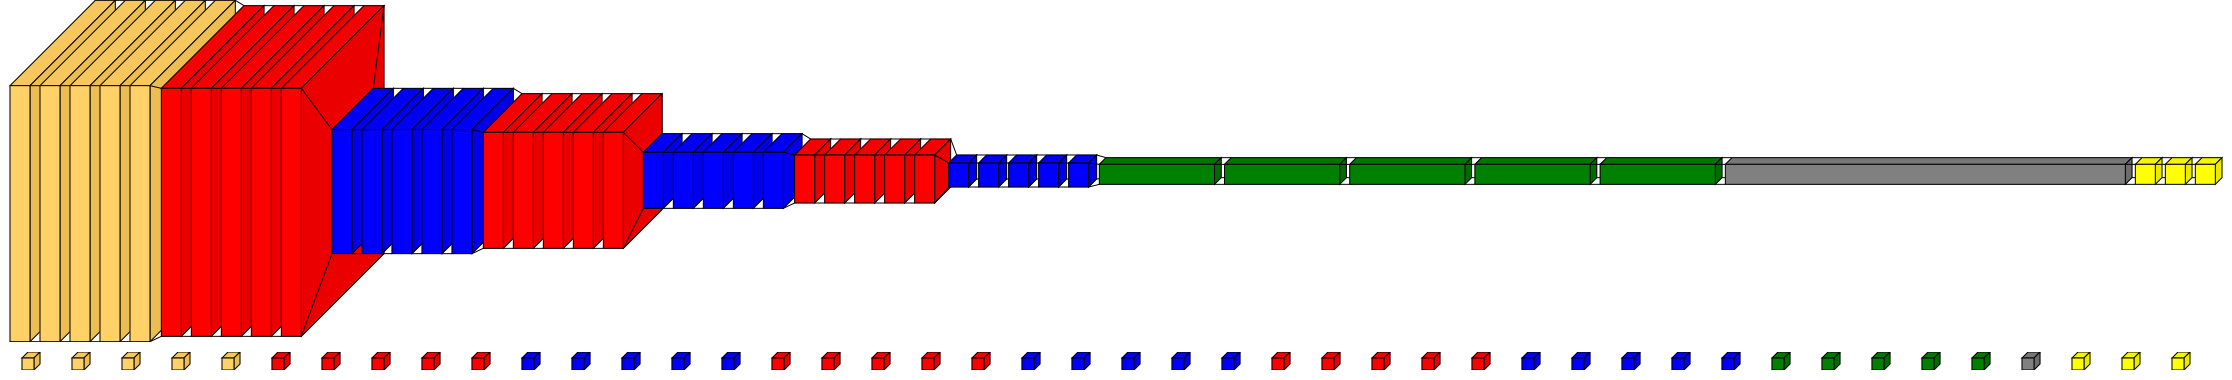

In [30]:
visualkeras.layered_view(model, color_map=color_map, show_dimension=True, legend=True, to_file='vgg16.png')

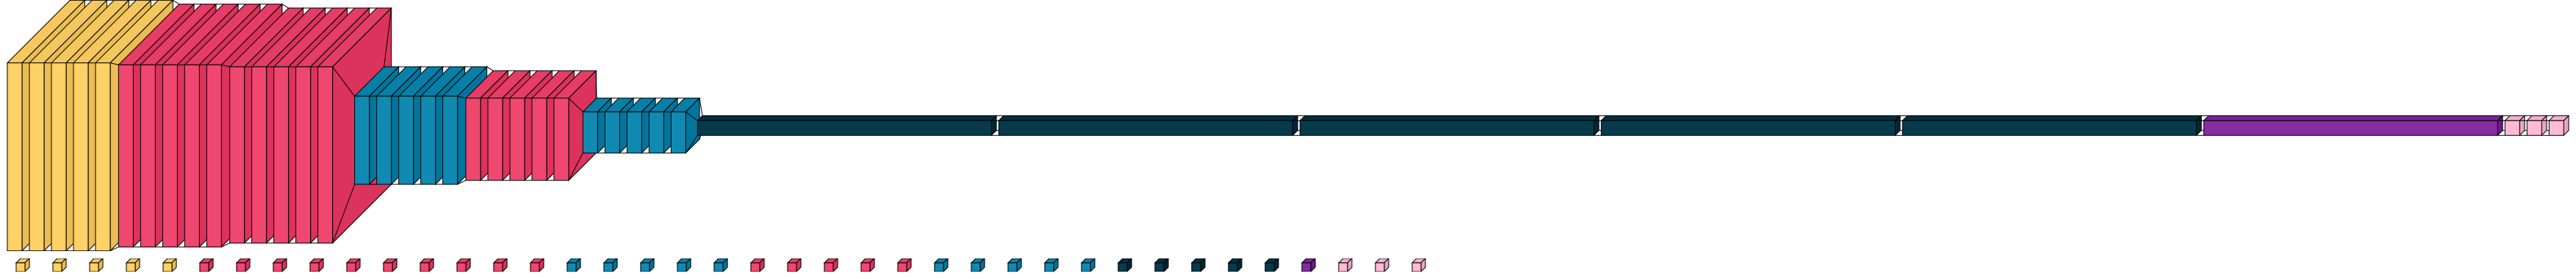

In [ ]:
visualkeras.layered_view(model, legend=True, show_dimension=True)

In [ ]:
# create VGG16
image_size = 224
model1 = Sequential()
model1.add(InputLayer(input_shape=(image_size, image_size, 3)))

model1.add(ZeroPadding2D((1, 1)))
model1.add(Conv2D(64, activation='relu', kernel_size=(3, 3)))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Conv2D(64, activation='relu', kernel_size=(3, 3)))

model1.add(MaxPooling2D((2, 2), strides=(2, 2)))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Conv2D(128, activation='relu', kernel_size=(3, 3)))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Conv2D(128, activation='relu', kernel_size=(3, 3)))

model1.add(MaxPooling2D((2, 2), strides=(2, 2)))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Conv2D(256, activation='relu', kernel_size=(3, 3)))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Conv2D(256, activation='relu', kernel_size=(3, 3)))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Conv2D(256, activation='relu', kernel_size=(3, 3)))

model1.add(MaxPooling2D((2, 2), strides=(2, 2)))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Conv2D(512, activation='relu', kernel_size=(3, 3)))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Conv2D(512, activation='relu', kernel_size=(3, 3)))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Conv2D(512, activation='relu', kernel_size=(3, 3)))

model1.add(MaxPooling2D((2, 2), strides=(2, 2)))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Conv2D(512, activation='relu', kernel_size=(3, 3)))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Conv2D(512, activation='relu', kernel_size=(3, 3)))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Conv2D(512, activation='relu', kernel_size=(3, 3)))
model1.add(MaxPooling2D())

model1.add(Flatten())

model1.add(Dense(4096, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(4096, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1000, activation='softmax'))